In [36]:
# import the necessary packages

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [37]:
# initialize the initial learning rate, number of epochs to train for,and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [41]:
# Set Directories and Labels
    
Dir = r"C:\Users\Abdelrahman Ragab\Downloads\Compressed\Project\dataset"
Labels = ["with_mask", "without_mask"]    

In [42]:
trainpath = r"""C:\Users\Abdelrahman Ragab\Downloads\Compressed\Project\\"""
for folder in  os.listdir(trainpath +"dataset") :
    files = glob.glob(pathname= str( trainpath +"dataset\\" + folder + '\*.png').replace('\\\\','\\'))
    print(f'For Validation data , found {len(files)} in folder {folder}')

For Validation data , found 2994 in folder without_mask
For Validation data , found 2994 in folder with_mask


In [43]:
# Load Dateset
data = []
label = []

for category in Labels:
    path = os.path.join(Dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        label.append(category)

In [44]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(label)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [45]:
# Split Dataset 

(trainX, testX, trainY, testY) = train_test_split(data, labels,
            test_size=0.20, stratify=labels)

In [46]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [47]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [48]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [49]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [50]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers[:-4]:
    layer.trainable = False

In [51]:
# Add checkpoint to save any improvement
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath= r"C:\Users\Abdelrahman Ragab\Downloads\Compressed\Project\FaceMaskDetection.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

callbacks_list = [
        checkpoint,
        early_stopping,
        learning_rate_reduction
    ]

In [52]:
# compile our model

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [53]:
# train the head of the network
History = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/20
149/149 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9273
Epoch 1: val_accuracy improved from -inf to 0.95409, saving model to C:\Users\Abdelrahman Ragab\Downloads\Compressed\Project\FaceMaskDetection.h5
149/149 [==============================] - 81s 532ms/step - loss: 0.2184 - accuracy: 0.9273 - val_loss: 0.1243 - val_accuracy: 0.9541 - lr: 1.0000e-04
Epoch 2/20
149/149 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9660
Epoch 2: val_accuracy improved from 0.95409 to 0.96494, saving model to C:\Users\Abdelrahman Ragab\Downloads\Compressed\Project\FaceMaskDetection.h5
149/149 [==============================] - 84s 566ms/step - loss: 0.0995 - accuracy: 0.9660 - val_loss: 0.0887 - val_accuracy: 0.9649 - lr: 1.0000e-04
Epoch 3/20
149/149 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9739
Epoch 3: val_accuracy improved from 0.96494 to 0.97496, saving model to C:\Users\Abdelrahman Ragab\Downloads\Compre

In [54]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)

In [55]:
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [17]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       385
without_mask       0.99      0.99      0.99       385

    accuracy                           0.99       770
   macro avg       0.99      0.99      0.99       770
weighted avg       0.99      0.99      0.99       770



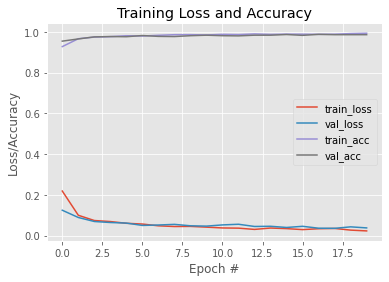

In [56]:
# plot the training loss and accuracy
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), History.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), History.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), History.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("plot.png")